<a href="https://colab.research.google.com/github/Fatima8024/NLP/blob/main/NLP_Similar_questions_Quora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Restart runtime

In [ ]:
!pip uninstall -y gensim numpy scipy
!pip install --no-cache-dir --force-reinstall \
    "numpy>=1.26.0,<2.0.0" \
    "scipy>=1.7.0,<1.14.0" \
    "gensim==4.3.3"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 357.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 330.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 213.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 199.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 251.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: smart-open
    Found existing installation: smart-open 7.1.0
    Uninstalling smart-open-7.1.0:
      Successfully uninstalled smart-open-7.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [ ]:
# ----------------------------------------
# Step 1: Import required libraries
# ----------------------------------------

import pandas as pd   #For Reading CSV files
import numpy as np    #For handling word vectors
import string         #For Removing punctuation during token cleaning

import nltk           #Tokenizing text and removing stopwords
from nltk.corpus import stopwords    #Removes common filler words
from nltk.tokenize import word_tokenize   #Breaks text into words

from sklearn.feature_extraction.text import TfidfVectorizer  # To convert text into vectors
from sklearn.metrics.pairwise import cosine_similarity   #Computes similarity between two vectors

#from gensim.models import Word2Vec    # For averaging word vectors to represent questions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sentence_transformers import SentenceTransformer  #Converting entire sentences into dense vectors that capture meaning

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# ====================================================
# 🔹 Step 2: Load Dataset
# ====================================================

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Define the file path (update if needed)
file_path = '/content/drive/MyDrive/NLP Project/questions.csv'

# Step 3: Read the CSV file
#import pandas as pd
df = pd.read_csv(file_path)

# Step 4: Confirm it's loaded
print("✅ Dataset loaded successfully!")
print(df.head())
print("Total question pairs processed:", len(df))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded successfully!
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?          

In [ ]:
# ====================================================
# 🔹 Step 3: Data Preprocessing
# Clean, lowercase, remove stopwords/punctuation, tokenize
# ====================================================
stop_words = set(stopwords.words('english'))     #Loads the stopping words

def preprocess(text):
    text = str(text).lower()     #Converts text to lowercase
    tokens = word_tokenize(text)   #Breaks text into list of individual words or "tokens"
    return [w for w in tokens if w not in stop_words and w not in string.punctuation]

# 🔍 Debug: test the preprocess function on the first row
print("🔍 Sample tokenization:", preprocess(df['question1'].iloc[0]))

# ✅ Apply preprocessing to both questions
df['q1_tokens'] = df['question1'].apply(preprocess)  #Runs preprocess() on every row in the question1 and question2 columns.
df['q2_tokens'] = df['question2'].apply(preprocess)  #Two new columns q1_tokens, q2_tokens, each holding a list of cleaned tokens
                                                     #are formed.

# Rejoin tokens for methods that require full sentences
df['q1_clean'] = df['q1_tokens'].apply(lambda x: " ".join(x)) #Converts the token lists back into plain text strings.
df['q2_clean'] = df['q2_tokens'].apply(lambda x: " ".join(x)) #As TF-IDF or Sentence-BERT expect full sentence strings, not token lists.

 #🔍 Confirm columns are created
print(df[['q1_clean', 'q2_clean']].head())

print("✅ Finished tokenization")    #Text preprocessing ensures that all models — TF-IDF, Word2Vec, SBERT — work on cleaned and normalized data

🔍 Sample tokenization: ['step', 'step', 'guide', 'invest', 'share', 'market', 'india']
                                            q1_clean  \
0          step step guide invest share market india   
1                  story kohinoor koh-i-noor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                            q2_clean  
0                step step guide invest share market  
1  would happen indian government stole kohinoor ...  
2               internet speed increased hacking dns  
3     find remainder math 23^ 24 /math divided 24,23  
4                      fish would survive salt water  
✅ Finished tokenization


🔢 Label Distribution:
is_duplicate
0    255045
1    149306
Name: count, dtype: int64

📊 Percentage Distribution:
is_duplicate
0    63.07515
1    36.92485
Name: count, dtype: float64


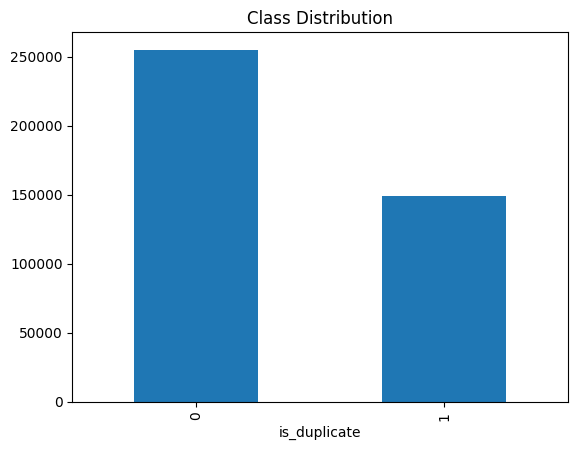


🔁 Repeated Questions Stats:
Total Unique Questions: 789801
Questions Appearing More Than Once: 13698


In [ ]:
# EDA: Distribution and Repeated Questions

# Distribution of duplicate and non-duplicate questions

import matplotlib.pyplot as plt


print("🔢 Label Distribution:")
print(df['is_duplicate'].value_counts())  # 0: not duplicate, 1: duplicate
print("\n📊 Percentage Distribution:")
print((df['is_duplicate'].value_counts() / df['is_duplicate'].count()) * 100)
df['is_duplicate'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

# Repeated questions
print("\n🔁 Repeated Questions Stats:")
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total Unique Questions:', np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Questions Appearing More Than Once:', x[x].shape[0])

In [ ]:
# ====================================================
# 🔹 Step 4: Method 1 – TF-IDF + Cosine Similarity
# Convert text to TF-IDF vectors and compute similarity
# and detect if two questions are duplicates.
# ====================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

tfidf = TfidfVectorizer()    #Converts text into vectors for similarity calculation
tfidf.fit(pd.concat([df['q1_clean'], df['q2_clean']]))   #Learns full vocabulary before transforming

q1_vec = tfidf.transform(df['q1_clean'])   #Converts cleaned text into sparse TF-IDF vectors
q2_vec = tfidf.transform(df['q2_clean'])

# Calculate cosine similarity
df['cosine_sim'] = [cosine_similarity(q1, q2)[0][0] for q1, q2 in zip(q1_vec, q2_vec)]   #Stores the similarity score (0–1) in a new column
X_tfidf = np.array(df['cosine_sim'].tolist()).reshape(-1, 1)
y = df['is_duplicate'].values


# Classify based on similarity threshold
threshold = 0.7
df['tfidf_pred'] = (df['cosine_sim'] >= threshold).astype(int)   #If similarity is above 0.7, classify as a duplicate (1), else not (0)

print("✅ TF-IDF complete")

# Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
  #Imports accuracy, F1, and confusion matrix for each model

print("\n🔹 TF-IDF + Cosine Similarity")
print("Accuracy:", accuracy_score(df['is_duplicate'], df['tfidf_pred']))
print(classification_report(df['is_duplicate'], df['tfidf_pred']))
print(confusion_matrix(df['is_duplicate'], df['tfidf_pred']))

✅ TF-IDF complete

🔹 TF-IDF + Cosine Similarity
Accuracy: 0.6605572880987063
              precision    recall  f1-score   support

           0       0.71      0.79      0.75    255045
           1       0.55      0.44      0.49    149306

    accuracy                           0.66    404351
   macro avg       0.63      0.61      0.62    404351
weighted avg       0.65      0.66      0.65    404351

[[201781  53264]
 [ 83990  65316]]


In [ ]:
# ====================================================
# 🔹 Step 5: Method 2 – Word2Vec + Logistic Regression
# Use word embeddings and a classifier
# ====================================================

import numpy as np
from gensim.models import Word2Vec

# Step1: Train Word2Vec model
sentences = df['q1_tokens'].tolist() + df['q2_tokens'].tolist()   #Combines all tokenized question pairs into one list of token lists
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2)    #Trains word embeddings
print("✅ Word2Vec training complete")

# Step 2: Create averaged vectors for each question
def avg_vector(tokens, model, dim=100):
    valid_words = [w for w in tokens if w in model.wv]
    return np.mean(model.wv[valid_words], axis=0) if valid_words else np.zeros(dim)

# Use apply instead of extra function
df['q1_vec'] = df['q1_tokens'].apply(lambda x: avg_vector(x, w2v_model))
df['q2_vec'] = df['q2_tokens'].apply(lambda x: avg_vector(x, w2v_model))

# Step 3: Create feature vectors using absolute difference
X_w2v = np.array([np.abs(q1 - q2) for q1, q2 in zip(df['q1_vec'], df['q2_vec'])])
y = df['is_duplicate'].values

# Step 4: Train/test split and model training
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

model_w2v = LogisticRegression(max_iter=1000)
model_w2v.fit(X_train_w2v, y_train)
y_pred = model_w2v.predict(X_test_w2v)

# Step 5: Evaluation
print("\n🔹 Word2Vec + Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


✅ Word2Vec training complete

🔹 Word2Vec + Logistic Regression
Accuracy: 0.6404891741168033
              precision    recall  f1-score   support

           0       0.67      0.86      0.75     50998
           1       0.53      0.27      0.36     29873

    accuracy                           0.64     80871
   macro avg       0.60      0.56      0.55     80871
weighted avg       0.61      0.64      0.60     80871

[[43789  7209]
 [21865  8008]]


In [ ]:
# ====================================================
# 🔹 Step 6: Method 3 – Sentence-BERT + Cosine Similarity
# Use transformer embeddings for semantic similarity
# ====================================================


from sentence_transformers import SentenceTransformer  # to load SBERT model
from sklearn.metrics.pairwise import cosine_similarity  # to compute similarity between sentence vectors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # for evaluation

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings
q1_embed = sbert_model.encode(df['q1_clean'].tolist(), show_progress_bar=True)
q2_embed = sbert_model.encode(df['q2_clean'].tolist(), show_progress_bar=True)

print("✅ Sentence-BERT complete")

# Cosine similarity
df['sbert_sim'] = [cosine_similarity([q1], [q2])[0][0] for q1, q2 in zip(q1_embed, q2_embed)]

# Classify using threshold
df['sbert_pred'] = (df['sbert_sim'] >= 0.7).astype(int)

# Evaluate
print("\n🔹 Sentence-BERT + Cosine Similarity")
print("Accuracy:", accuracy_score(df['is_duplicate'], df['sbert_pred']))
print(classification_report(df['is_duplicate'], df['sbert_pred']))
print(confusion_matrix(df['is_duplicate'], df['sbert_pred']))


Batches:   0%|          | 0/12636 [00:00<?, ?it/s]

Batches:   0%|          | 0/12636 [00:00<?, ?it/s]

✅ Sentence-BERT complete

🔹 Sentence-BERT + Cosine Similarity
Accuracy: 0.7254390368763772
              precision    recall  f1-score   support

           0       0.88      0.65      0.75    255045
           1       0.59      0.86      0.70    149306

    accuracy                           0.73    404351
   macro avg       0.74      0.75      0.72    404351
weighted avg       0.78      0.73      0.73    404351

[[165638  89407]
 [ 21612 127694]]


In [ ]:
# TF-IDF + Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train_tf, y_train)

# Word2Vec + Logistic Regression
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
model_w2v = LogisticRegression(max_iter=200)
model_w2v.fit(X_train_w2v, y_train)


LogisticRegression(max_iter=200)

In [ ]:
import joblib

# Save trained models
joblib.dump(model_tfidf, "model_tfidf.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(model_w2v, "model_w2v.pkl")
w2v_model.save("word2vec.model")  # Save Word2Vec separately


In [ ]:
# ====================================================
# 🔹 Step 7: Final Accuracy Comparison
# ====================================================
print("\n📊 Final Accuracy Comparison:")
print("TF-IDF      :", accuracy_score(df['is_duplicate'], df['tfidf_pred']))
print("Word2Vec    :", accuracy_score(y_test, y_pred))
print("Sentence-BERT:", accuracy_score(df['is_duplicate'], df['sbert_pred']))



📊 Final Accuracy Comparison:
TF-IDF      : 0.6605572880987063
Word2Vec    : 0.6404891741168033
Sentence-BERT: 0.7254390368763772


In [ ]:
# ====================================================
# 🔹 Step 8: Import Libraries for Accuracy Comparison
# ====================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# ====================================================
# 🔹 Step 9: Create Comparison Table (Accuracy + F1 Score)

# ====================================================

print(df.columns)

# Collect metrics
methods = ['TF-IDF + Cosine', 'Word2Vec + Logistic Regression', 'Sentence-BERT + Cosine']
accuracies = [
    accuracy_score(df['is_duplicate'], df['tfidf_pred']),
    accuracy_score(y_test, y_pred),
    accuracy_score(df['is_duplicate'], df['sbert_pred'])
]

# Get F1-scores
f1_scores = [
    classification_report(df['is_duplicate'], df['tfidf_pred'], output_dict=True)['weighted avg']['f1-score'],
    classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score'],
    classification_report(df['is_duplicate'], df['sbert_pred'], output_dict=True)['weighted avg']['f1-score']
]

# Build DataFrame
results_df = pd.DataFrame({
    'Method': methods,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})


# Show results
print("🔍 Final Model Comparison:")
display(results_df)



Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_tokens', 'q2_tokens', 'q1_clean', 'q2_clean', 'cosine_sim',
       'tfidf_pred', 'q1_vec', 'q2_vec', 'sbert_sim', 'sbert_pred'],
      dtype='object')
🔍 Final Model Comparison:


,Method,Accuracy,F1 Score
0,TF-IDF + Cosine,0.660557,0.650733
1,Word2Vec + Logistic Regression,0.640489,0.604646
2,Sentence-BERT + Cosine,0.725439,0.729797


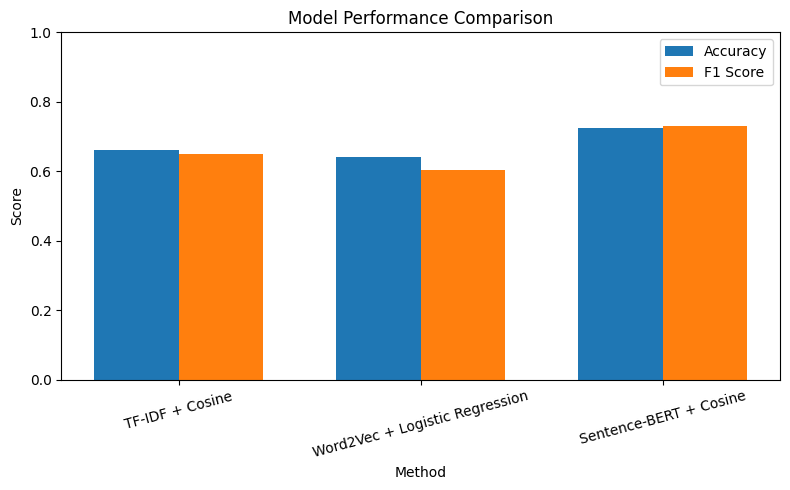

In [ ]:
# ====================================================
# 🔹 Step 10: Plot Bar Chart
# ====================================================

# Plot comparison
plt.figure(figsize=(8, 5))
bar_width = 0.35
index = range(len(methods))

plt.bar(index, accuracies, bar_width, label='Accuracy')
plt.bar([i + bar_width for i in index], f1_scores, bar_width, label='F1 Score')

plt.xlabel('Method')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks([i + bar_width / 2 for i in index], methods, rotation=15)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


# ***What the Results Show***

| Model                      | Accuracy | F1 Score | Summary                                                 |
| -------------------------- | -------- | -------- | ------------------------------------------------------- |
| **TF-IDF + Cosine**        | \~0.66   | \~0.65   | Performs moderately well; slightly balanced             |
| **Word2Vec + Logistic**    | \~0.64   | \~0.60   | Lower F1 score → more false positives or negatives      |
| **Sentence-BERT + Cosine** | \~0.72   | \~0.72   | Best overall performance — both in accuracy and balance |


✅** 1. Sentence-BERT is the best model**
Highest accuracy and F1 score

Captures semantic meaning better than TF-IDF or Word2Vec

Ideal for duplicate detection where meaning matters more than wording

⚠️ **2. Word2Vec performs worse than expected**
Accuracy is decent, but F1 score drops, suggesting it may:

Predict one class more than the other

Be less effective on shorter/rare-word questions

Could be improved with better tuning or more training data

⚖️** 3. TF-IDF is surprisingly competitive**
Simpler, faster, and performs decently

May be a good lightweight baseline when resources are limited

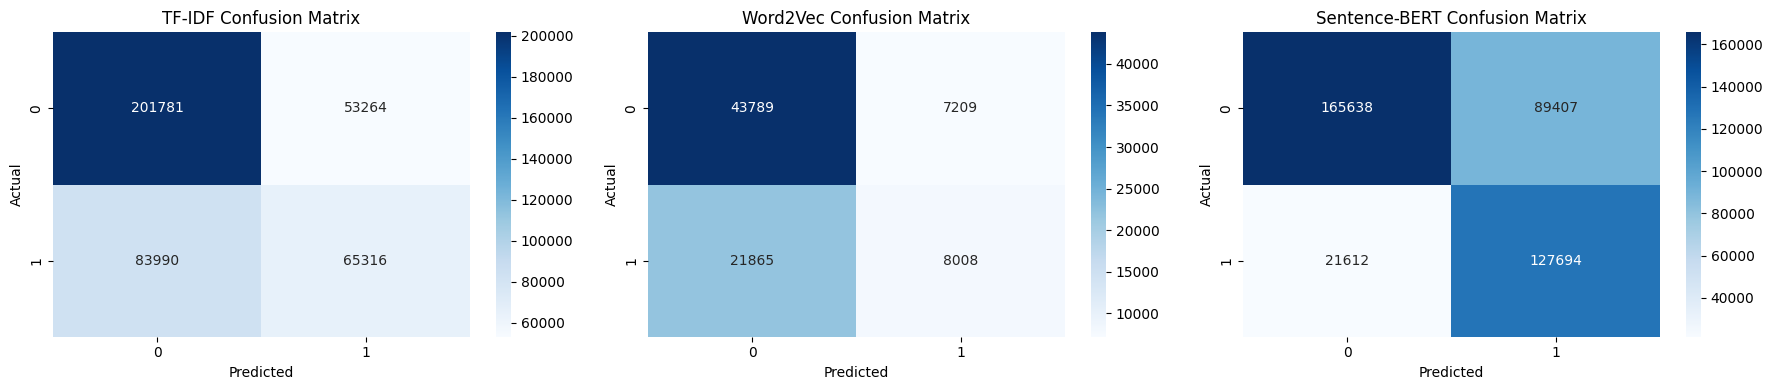

In [ ]:
# ====================================================
# 🔹 Step 11: Show Confusion Matrices
# ====================================================

# Confusion matrices
cm_tfidf = confusion_matrix(df['is_duplicate'], df['tfidf_pred'])
cm_w2v   = confusion_matrix(y_test, y_pred)
cm_sbert = confusion_matrix(df['is_duplicate'], df['sbert_pred'])

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, cm, title in zip(axes,
                         [cm_tfidf, cm_w2v, cm_sbert],
                         ['TF-IDF', 'Word2Vec', 'Sentence-BERT']):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()


# **Confusion Matrix Terms **
Each matrix compares:

Actual labels (rows) vs Predicted labels (columns)

Predicted: 0	Predicted: 1
Actual: 0	TN (True Negatives)	FP (False Positives)

Actual: 1	FN (False Negatives)	TP (True Positives)

TF-IDF + Cosine Similarity
Many false negatives (83k): TF-IDF fails to catch many actual duplicates.

Decent TN and TP: Predicts non-duplicates well.

🔻 Weak at semantic similarity: Since it’s based on exact word overlap.

In [ ]:
# ====================================================
# 🔹 Step 12: Show Sample Similar Question Predictions
# ====================================================


# Number of examples to show
n = 5

# Sample duplicates detected by TF-IDF model
print("🔍 TF-IDF Predictions (Detected as Duplicates):")
sample_tfidf = df[(df['tfidf_pred'] == 1)].sample(n)
for i, row in sample_tfidf.iterrows():
    print(f"\nQ1: {row['question1']}")
    print(f"Q2: {row['question2']}")
    print(f"Cosine Similarity: {row['cosine_sim']:.3f}")

# Create a DataFrame with the indices from the original df
df_reset = df.reset_index(drop=True)
df_test = pd.DataFrame(X_test)
df_test['pred'] = y_pred

# Sample 5 predicted duplicates
sample_idx = df_test[df_test['pred'] == 1].sample(n).index


# Sample duplicates detected by Word2Vec model
print("\n\n🔍 Word2Vec + Logistic Regression Predictions (Detected as Duplicates):")
# We'll use the same X_test/y_pred from earlier
import numpy as np
df_test = pd.DataFrame(X_test, columns=[f'feat_{i}' for i in range(X_test.shape[1])])
df_test['pred'] = y_pred
df_test['index'] = y_test.tolist()
sample_idx = df_test[df_test['pred'] == 1].sample(n).index

for i in sample_idx:
    print(f"\nQ1: {df_reset.iloc[X_train.shape[0]+i]['question1']}")
    print(f"Q2: {df_reset.iloc[X_train.shape[0] + i]['question2']}")

# Sample duplicates detected by Sentence-BERT model
print("\n\n🔍 Sentence-BERT Predictions (Detected as Duplicates):")
sample_sbert = df[(df['sbert_pred'] == 1)].sample(n)
for i, row in sample_sbert.iterrows():
    print(f"\nQ1: {row['question1']}")
    print(f"Q2: {row['question2']}")
    print(f"SBERT Similarity: {row['sbert_sim']:.3f}")


🔍 TF-IDF Predictions (Detected as Duplicates):

Q1: What is the difference between short-tempered and high-tempered people?
Q2: Who are likely to be more corrupt, short-tempered or cool tempered people?
Cosine Similarity: 0.796

Q1: Which is the best Free Antivirus for Mobile?
Q2: Which is best free antivirus for mobile?
Cosine Similarity: 1.000

Q1: How should a 17-year-old invest time?
Q2: How should a 17-year-old invest their time?
Cosine Similarity: 1.000

Q1: What is the Personal property Security Act 2009 and how is Nova Scotia's different from Ontario's?
Q2: What is the Personal Property Security Act and how is Nova Scotia's different from Ontario's?
Cosine Similarity: 0.920

Q1: Is time travel possible? If yes? How?
Q2: Is time travel possible? If yes how
Cosine Similarity: 1.000


🔍 Word2Vec + Logistic Regression Predictions (Detected as Duplicates):

Q1: What can I do to improve my English speaking?
Q2: How can I improve my English in a very short time?

Q1: How to hack Wifi?

In [ ]:
import os
print(os.listdir()) #Returns a list of files and folders in the current working directory


['.config', 'word2vec.model', 'model_w2v.pkl', 'drive', 'tfidf_vectorizer.pkl', 'model_tfidf.pkl', 'sample_data']


In [ ]:
pip install -q streamlit pyngrok nltk gensim joblib sentence-transformers


In [ ]:
#====================================================
# 🔹 Step 13: Streamlit App for Question Comparison
# ====================================================

!pip install gradio

import gradio as gr
import numpy as np
import joblib
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# Load models
model_tfidf = joblib.load("model_tfidf.pkl")
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")
model_w2v = joblib.load("model_w2v.pkl")
w2v_model = joblib.load("word2vec.model")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    return [w for w in tokens if w not in stop_words and w not in string.punctuation]

def avg_vector(tokens, model, dim=100):
    valid_words = [w for w in tokens if w in model.wv]
    return np.mean(model.wv[valid_words], axis=0) if valid_words else np.zeros(dim)

def predict(q1, q2):
    q1_tokens = preprocess(q1)
    q2_tokens = preprocess(q2)
    q1_clean = " ".join(q1_tokens)
    q2_clean = " ".join(q2_tokens)

    # TF-IDF
    sim_tfidf = cosine_similarity(tfidf_vectorizer.transform([q1_clean]),
                                  tfidf_vectorizer.transform([q2_clean]))[0][0]
    pred_tfidf = model_tfidf.predict([[sim_tfidf]])[0]

    # Word2Vec
    vec1 = avg_vector(q1_tokens, w2v_model)
    vec2 = avg_vector(q2_tokens, w2v_model)
    pred_w2v = model_w2v.predict([np.abs(vec1 - vec2)])[0]

    # SBERT
    emb1 = sbert_model.encode([q1_clean])[0]
    emb2 = sbert_model.encode([q2_clean])[0]
    sim_sbert = cosine_similarity([emb1], [emb2])[0][0]
    pred_sbert = int(sim_sbert >= 0.7)

    return {
        "TF-IDF": f"{sim_tfidf:.3f} → {'Duplicate' if pred_tfidf else 'Not Duplicate'}",
        "Word2Vec": "Duplicate" if pred_w2v else "Not Duplicate",
        "SBERT": f"{sim_sbert:.3f} → {'Duplicate' if pred_sbert else 'Not Duplicate'}"
    }

gr.Interface(
    fn=predict,
    inputs=["text", "text"],
    outputs=["text", "text", "text"],
    title="🔍 Quora Question Similarity Checker",
    description="Compare two questions using TF-IDF, Word2Vec, and SBERT models."
).launch()



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d9385b4d4af1657fb3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
